# Latest experiment

In [ ]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

## Housing Data

In [ ]:
class HouseSalesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, train = True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.housing_data = pd.read_csv(csv_file)
        self.x = self.housing_data.drop('price', axis = 1)
        df = self.housing_data.drop('date', axis = 1)
        self.x = (df-df.mean())/df.std()
        self.y = self.housing_data[['price']]/1000

        if train:
          self.x = self.x.iloc[:18000, :]
          self.y = self.y.iloc[:18000, :]

        else:
          self.x = self.x.iloc[18000:, :]
          self.y = self.y.iloc[18000:, :]  


        print('Length = ', len(self.y))
        self.x = torch.Tensor(self.x.values).to(device)
        self.y = torch.Tensor(self.y.values).to(device)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # if self.transform:
        #     sample = self.transform(sample)

        features = self.x[idx]
        price = self.y[idx]
        return {'features': features, 'price': price}

In [ ]:
train_dataset = HouseSalesDataset(csv_file='kc_house_data.csv',
                                    root_dir='/', train = True)

test_dataset = HouseSalesDataset(csv_file='kc_house_data.csv',
                                    root_dir='/', train = False)

train_loader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

Length =  18000
Length =  3613


In [ ]:
def test(net, test_loader, loss):
  running_loss = 0.0
  for i, data in enumerate(test_loader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data['features'].to(device), data['price'].to(device)
      # print(inputs)
      # forward
      outputs = net(inputs)
      # print(outputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()

  running_loss = running_loss / 2613
  print("Avg Loss during Testing - ", running_loss)
  return running_loss

In [ ]:
def train(net, train_loader, num_epoch, optimizer, criterion, running_loss_batch = 200):
  for epoch in range(num_epoch):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data['features'].to(device), data['price'].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()
          # print(inputs)
          # forward + backward + optimize
          outputs = net(inputs)
          # print(outputs)
          loss = criterion(outputs, labels)
          # for name, param in net.named_parameters():
          #   if param.requires_grad and name == 'fc2.weight':
          #     print(name, param.data)
          # print(loss)
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          if i % running_loss_batch == (running_loss_batch-1):    # print every 150 mini-batches
              print('[%d, %5d] loss: %.6f' %
                    (epoch + 1, i + 1, running_loss / running_loss_batch))
              running_loss = 0.0

  print('Finished Training')

### 3 layer

In [ ]:
def print_sparsity(net):
  print(
      "Sparsity in fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc1.weight == 0))
          / float(net.fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc2.weight == 0))
          / float(net.fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in fc3.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc3.weight == 0))
          / float(net.fc3.weight.nelement())
      )
  )
  print(
      "Global sparsity: {:.2f}%".format(
          100. * float(
              + torch.sum(net.fc1.weight == 0)
              + torch.sum(net.fc2.weight == 0)
              + torch.sum(net.fc3.weight == 0)
          )
          / float(
              + net.fc1.weight.nelement()
              + net.fc2.weight.nelement()
              + net.fc3.weight.nelement()
          )
      )
  )

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 16)
        self.fc2 = nn.Linear(16, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [ ]:
# # criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# # optimizer = optim.SGD(net.parameters(), lr=10)
optimizer = optim.Adam(net.parameters(), lr=0.1)

In [ ]:
# Testing before training
test(net, test_loader, criterion)

Avg Loss during Testing -  20565.146377487563


20565.146377487563

In [ ]:
# Full cycle

parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
)

batch_loss = 560
epoch = 50

results_base_l1 = []
results_finetune_l1 = []

results_base_l2 = []
results_finetune_l2 = []


# Network
net = Net().to(device)
print_sparsity(net)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)

train(net, train_loader, epoch, optimizer, criterion, batch_loss)
loss_mse = test(net, test_loader, criterion)

results_base_l1.append(loss_mse)
results_finetune_l1.append(loss_mse)
results_base_l2.append(loss_mse)
results_finetune_l2.append(loss_mse)

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

prune_values = [0.2, 0.4, 0.6, 0.8, 0.9]
pruning_methods = [0,1]


for prune_value in prune_values:
  for pruning_method in pruning_methods:
  # Each prune value experiment is independent
    net = Net().to(device)
    net.load_state_dict(torch.load(PATH))
    
    parameters_to_prune = (
      (net.fc1, 'weight'),
      (net.fc2, 'weight'),
      (net.fc3, 'weight'),
    )
    optimizer = optim.Adam(net.parameters(), lr=0.1)
    
    if pruning_method == 0:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.L1Unstructured,
          amount=prune_value,
      )
    else:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.RandomUnstructured,
          amount=prune_value,
      )

    print_sparsity(net)
    
    base_loss = test(net, test_loader, criterion)

    train(net, train_loader, epoch, optimizer, criterion, batch_loss)
    finetune_loss = test(net, test_loader, criterion)
    
    if pruning_method == 0:
      results_base_l1.append(base_loss)
      results_finetune_l1.append(finetune_loss)

      print('L1 values - ', results_base_l1)
      print('L1 values - ', results_finetune_l1)
    else:
      results_base_l2.append(base_loss)
      results_finetune_l2.append(finetune_loss)

      print('L2 values - ', results_base_l2)
      print('L2 values - ', results_finetune_l2)

Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Global sparsity: 0.00%
[1,   560] loss: 300429.697391
[2,   560] loss: 171622.900991
[3,   560] loss: 121545.484583
[4,   560] loss: 99901.555323
[5,   560] loss: 87849.517773
[6,   560] loss: 80611.654949
[7,   560] loss: 76567.878448
[8,   560] loss: 74023.100490
[9,   560] loss: 68949.733404
[10,   560] loss: 71020.153735
[11,   560] loss: 70246.509391
[12,   560] loss: 69164.522939
[13,   560] loss: 68535.724574
[14,   560] loss: 70629.258571
[15,   560] loss: 69766.748472
[16,   560] loss: 68854.450584
[17,   560] loss: 68397.126484
[18,   560] loss: 68261.658672
[19,   560] loss: 68744.722768
[20,   560] loss: 70210.063644
[21,   560] loss: 69265.856726
[22,   560] loss: 68737.477787
[23,   560] loss: 66958.531906
[24,   560] loss: 68181.123846
[25,   560] loss: 68130.528374
[26,   560] loss: 67675.490859
[27,   560] loss: 68674.469001
[28,   560] loss: 70911.522883
[29,   560] loss: 69917.6

In [ ]:
results_base_l1

[3084.206892969049,
 3071.4166165865386,
 2921.015459062859,
 3162.526452024732,
 7082.999798184558,
 7085.032605900785]

In [ ]:
results_finetune_l1

[3084.206892969049,
 2794.745364972015,
 2877.615210456133,
 1598.687015642939,
 6322.3426646814005,
 6317.369332723402]

In [ ]:
results_base_l2

[3084.206892969049,
 6333.156765750574,
 6335.233910077019,
 12067.471976057213,
 19641.623457233065,
 12070.307178052048]

In [ ]:
results_finetune_l2

[3084.206892969049,
 3312.844593140069,
 6294.461409897627,
 6305.679976021335,
 6326.821536847015,
 6308.038433134807]

In [ ]:
x_coord = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

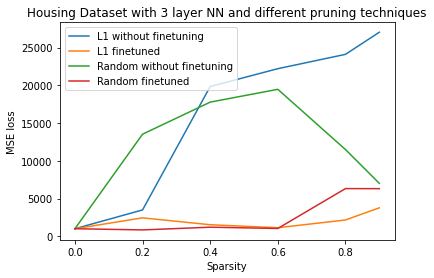

In [ ]:
import matplotlib.pyplot as plt

plt.title('Housing Dataset with 3 layer NN and different pruning techniques')
plt.plot(x_coord, results_base_l1, label = 'L1 without finetuning')
plt.plot(x_coord, results_finetune_l1, label = 'L1 finetuned')
plt.plot(x_coord, results_base_l2, label = 'Random without finetuning')
plt.plot(x_coord, results_finetune_l2, label = 'Random finetuned')
plt.ylabel('MSE loss')
plt.xlabel('Sparsity')
plt.legend()
plt.show()

### 5 layer

In [ ]:
def print_sparsity(net):
  print(
      "Sparsity in fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc1.weight == 0))
          / float(net.fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc2.weight == 0))
          / float(net.fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in fc3.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc3.weight == 0))
          / float(net.fc3.weight.nelement())
      )
  )
  print(
      "Sparsity in fc4.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc4.weight == 0))
          / float(net.fc4.weight.nelement())
      )
  )
  print(
      "Sparsity in fc5.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc5.weight == 0))
          / float(net.fc5.weight.nelement())
      )
  )
  print(
      "Global sparsity: {:.2f}%".format(
          100. * float(
              + torch.sum(net.fc1.weight == 0)
              + torch.sum(net.fc2.weight == 0)
              + torch.sum(net.fc3.weight == 0)
              + torch.sum(net.fc4.weight == 0)
              + torch.sum(net.fc5.weight == 0)
          )
          / float(
              + net.fc1.weight.nelement()
              + net.fc2.weight.nelement()
              + net.fc3.weight.nelement()
              + net.fc4.weight.nelement()
              + net.fc5.weight.nelement()
          )
      )
  )

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, 1)

    def forward(self, x):
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x)) 
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

net = Net().to(device)

In [ ]:
# # criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# # optimizer = optim.SGD(net.parameters(), lr=10)
optimizer = optim.Adam(net.parameters(), lr=0.1)

In [ ]:
# Testing before training
test(net, test_loader, criterion)

Avg Loss during Testing -  20563.5038090796


20563.5038090796

In [ ]:
# Full cycle

parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.fc4, 'weight'),
    (net.fc5, 'weight'),
)

batch_loss = 560
epoch = 50

results_base_l1 = []
results_finetune_l1 = []

results_base_l2 = []
results_finetune_l2 = []

# Network
net = Net().to(device)
print_sparsity(net)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)

train(net, train_loader, epoch, optimizer, criterion, batch_loss)
loss_mse = test(net, test_loader, criterion)

results_base_l1.append(loss_mse)
results_finetune_l1.append(loss_mse)
results_base_l2.append(loss_mse)
results_finetune_l2.append(loss_mse)

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

prune_values = [0.2, 0.4, 0.6, 0.8, 0.9]
pruning_methods = [0,1]


for prune_value in prune_values:
  for pruning_method in pruning_methods:
  # Each prune value experiment is independent
    net = Net().to(device)
    net.load_state_dict(torch.load(PATH))
    
    parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.fc4, 'weight'),
    (net.fc5, 'weight'),
    )

    optimizer = optim.Adam(net.parameters(), lr=0.1)
    
    if pruning_method == 0:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.L1Unstructured,
          amount=prune_value,
      )
    else:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.RandomUnstructured,
          amount=prune_value,
      )

    print_sparsity(net)
    
    base_loss = test(net, test_loader, criterion)

    train(net, train_loader, epoch, optimizer, criterion, batch_loss)
    finetune_loss = test(net, test_loader, criterion)
    
    if pruning_method == 0:
      results_base_l1.append(base_loss)
      results_finetune_l1.append(finetune_loss)

      print('L1 values - ', results_base_l1)
      print('L1 values - ', results_finetune_l1)
    else:
      results_base_l2.append(base_loss)
      results_finetune_l2.append(finetune_loss)

      print('L2 values - ', results_base_l2)
      print('L2 values - ', results_finetune_l2)

Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Sparsity in fc4.weight: 0.00%
Sparsity in fc5.weight: 0.00%
Global sparsity: 0.00%
[1,   560] loss: 300980.459431
[2,   560] loss: 174882.238494
[3,   560] loss: 139353.537413
[4,   560] loss: 132792.285931
[5,   560] loss: 129940.992815
[6,   560] loss: 101811.947642
[7,   560] loss: 94892.837228
[8,   560] loss: 89747.465548
[9,   560] loss: 88538.374803
[10,   560] loss: 85692.721995
[11,   560] loss: 82387.190761
[12,   560] loss: 81546.869918
[13,   560] loss: 80957.576357
[14,   560] loss: 76214.250963
[15,   560] loss: 73841.818269
[16,   560] loss: 73040.120537
[17,   560] loss: 80155.522780
[18,   560] loss: 80305.074789
[19,   560] loss: 80466.552543
[20,   560] loss: 81626.449226
[21,   560] loss: 78184.990941
[22,   560] loss: 70973.553913
[23,   560] loss: 75925.043251
[24,   560] loss: 81914.758015
[25,   560] loss: 82915.583566
[26,   560] loss: 82367.430047
[27,   560] loss: 80961.

In [ ]:
results_base_l1

[4367.997509447952,
 4538.163779210917,
 4616.783823520618,
 4861.873330164083,
 4772.666032816685,
 7115.1995461394945]

In [ ]:
results_finetune_l1

[4367.997509447952,
 5731.2301682692305,
 5417.997559528081,
 5366.928613767102,
 4845.17295882367,
 6298.660993410352]

In [ ]:
results_base_l2

[4367.997509447952,
 7823.647266970436,
 8909.276233017605,
 15094.460811925946,
 10264.367029037505,
 6557.644667288557]

In [ ]:
results_finetune_l2

[4367.997509447952,
 4704.056339396766,
 2872.6591793137677,
 4321.284145677861,
 6308.893643262055,
 6317.372766575775]

In [ ]:
x_coord = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

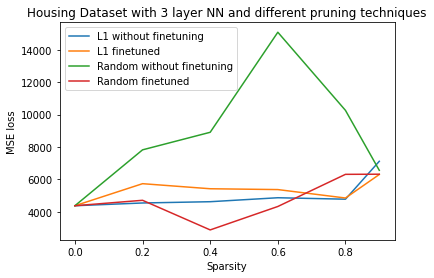

In [ ]:
import matplotlib.pyplot as plt

plt.title('Housing Dataset with 5 layer NN and different pruning techniques')
plt.plot(x_coord, results_base_l1, label = 'L1 without finetuning')
plt.plot(x_coord, results_finetune_l1, label = 'L1 finetuned')
plt.plot(x_coord, results_base_l2, label = 'Random without finetuning')
plt.plot(x_coord, results_finetune_l2, label = 'Random finetuned')
plt.ylabel('MSE loss')
plt.xlabel('Sparsity')
plt.legend()
plt.show()

### 10 layer

In [ ]:
def print_sparsity(net):
  print(
      "Sparsity in fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc1.weight == 0))
          / float(net.fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc2.weight == 0))
          / float(net.fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in fc3.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc3.weight == 0))
          / float(net.fc3.weight.nelement())
      )
  )
  print(
      "Sparsity in fc4.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc4.weight == 0))
          / float(net.fc4.weight.nelement())
      )
  )
  print(
      "Sparsity in fc5.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc5.weight == 0))
          / float(net.fc5.weight.nelement())
      )
  )

  print(
      "Sparsity in fc6.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc6.weight == 0))
          / float(net.fc6.weight.nelement())
      )
  )
  print(
      "Sparsity in fc7.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc7.weight == 0))
          / float(net.fc7.weight.nelement())
      )
  )
  print(
      "Sparsity in fc8.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc8.weight == 0))
          / float(net.fc8.weight.nelement())
      )
  )
  print(
      "Sparsity in fc9.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc9.weight == 0))
          / float(net.fc9.weight.nelement())
      )
  )
  print(
      "Sparsity in fc10.weight: {:.2f}%".format(
          100. * float(torch.sum(net.fc10.weight == 0))
          / float(net.fc10.weight.nelement())
      )
  )

  print(
      "Global sparsity: {:.2f}%".format(
          100. * float(
              + torch.sum(net.fc1.weight == 0)
              + torch.sum(net.fc2.weight == 0)
              + torch.sum(net.fc3.weight == 0)
              + torch.sum(net.fc4.weight == 0)
              + torch.sum(net.fc5.weight == 0)
              + torch.sum(net.fc6.weight == 0)
              + torch.sum(net.fc7.weight == 0)
              + torch.sum(net.fc8.weight == 0)
              + torch.sum(net.fc9.weight == 0)
              + torch.sum(net.fc10.weight == 0)
          )
          / float(
              + net.fc1.weight.nelement()
              + net.fc2.weight.nelement()
              + net.fc3.weight.nelement()
              + net.fc4.weight.nelement()
              + net.fc5.weight.nelement()
              + net.fc6.weight.nelement()
              + net.fc7.weight.nelement()
              + net.fc8.weight.nelement()
              + net.fc9.weight.nelement()
              + net.fc10.weight.nelement()
          )
      )
  )

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 20)
        self.fc2 = nn.Linear(20, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 8)
        self.fc7 = nn.Linear(8, 4)
        self.fc8 = nn.Linear(4, 4)
        self.fc9 = nn.Linear(4, 2)
        self.fc10 = nn.Linear(2, 1)

    def forward(self, x):
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x)) 
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x)) 
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        x = torch.tanh(self.fc9(x))
        x = self.fc10(x)
        return x

net = Net().to(device)

In [ ]:
# # criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# # optimizer = optim.SGD(net.parameters(), lr=10)
optimizer = optim.Adam(net.parameters(), lr=0.1)

In [ ]:
# Testing before training
test(net, test_loader, criterion)

Avg Loss during Testing -  20534.913569173365


20534.913569173365

In [ ]:
# Full cycle

parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.fc4, 'weight'),
    (net.fc5, 'weight'),
    (net.fc6, 'weight'),
    (net.fc7, 'weight'),
    (net.fc8, 'weight'),
    (net.fc9, 'weight'),
    (net.fc10, 'weight'),
    )

batch_loss = 560
epoch = 50

results_base_l1 = []
results_finetune_l1 = []

results_base_l2 = []
results_finetune_l2 = []

# Network
net = Net().to(device)
print_sparsity(net)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)

train(net, train_loader, epoch, optimizer, criterion, batch_loss)
loss_mse = test(net, test_loader, criterion)

results_base_l1.append(loss_mse)
results_finetune_l1.append(loss_mse)
results_base_l2.append(loss_mse)
results_finetune_l2.append(loss_mse)

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

prune_values = [0.2, 0.4, 0.6, 0.8, 0.9]
pruning_methods = [0,1]


for prune_value in prune_values:
  for pruning_method in pruning_methods:
  # Each prune value experiment is independent
    net = Net().to(device)
    net.load_state_dict(torch.load(PATH))
    
    parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.fc4, 'weight'),
    (net.fc5, 'weight'),
    (net.fc6, 'weight'),
    (net.fc7, 'weight'),
    (net.fc8, 'weight'),
    (net.fc9, 'weight'),
    (net.fc10, 'weight'),
    )
    
    optimizer = optim.Adam(net.parameters(), lr=0.1)
    
    if pruning_method == 0:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.L1Unstructured,
          amount=prune_value,
      )
    else:
      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.RandomUnstructured,
          amount=prune_value,
      )

    print_sparsity(net)
    
    base_loss = test(net, test_loader, criterion)

    train(net, train_loader, epoch, optimizer, criterion, batch_loss)
    finetune_loss = test(net, test_loader, criterion)
    
    if pruning_method == 0:
      results_base_l1.append(base_loss)
      results_finetune_l1.append(finetune_loss)

      print('L1 values - ', results_base_l1)
      print('L1 values - ', results_finetune_l1)
    else:
      results_base_l2.append(base_loss)
      results_finetune_l2.append(finetune_loss)

      print('L2 values - ', results_base_l2)
      print('L2 values - ', results_finetune_l2)

Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Sparsity in fc4.weight: 0.00%
Sparsity in fc5.weight: 0.00%
Sparsity in fc6.weight: 0.00%
Sparsity in fc7.weight: 0.00%
Sparsity in fc8.weight: 0.00%
Sparsity in fc9.weight: 0.00%
Sparsity in fc10.weight: 0.00%
Global sparsity: 0.00%
[1,   560] loss: 339013.993401
[2,   560] loss: 230165.709033
[3,   560] loss: 171416.415817
[4,   560] loss: 145306.897642
[5,   560] loss: 134444.265960
[6,   560] loss: 133005.179708
[7,   560] loss: 132446.382342
[8,   560] loss: 132744.403749
[9,   560] loss: 132834.166466
[10,   560] loss: 132738.260969
[11,   560] loss: 132625.727047
[12,   560] loss: 132942.565116
[13,   560] loss: 132718.372911
[14,   560] loss: 131446.753735
[15,   560] loss: 132494.361963
[16,   560] loss: 132995.588316
[17,   560] loss: 132460.824937
[18,   560] loss: 132835.106306
[19,   560] loss: 132794.888853
[20,   560] loss: 132928.141068
[21,   560] loss: 132503.659710
[22,   560] l

In [ ]:
results_base_l1

[6321.074424302765,
 6324.8538893573,
 6323.009651262916,
 6321.356218456994,
 6335.608402548555,
 6323.960129490767]

In [ ]:
results_finetune_l1

[6321.074424302765,
 6299.219768046785,
 6310.706497560275,
 6317.747283713643,
 6310.503429367585,
 6318.053090915614]

In [ ]:
results_base_l2

[6321.074424302765,
 6321.766012186663,
 6335.08767460773,
 13137.98205785974,
 8495.670463786835,
 13149.729417814773]

In [ ]:
results_finetune_l2

[6321.074424302765,
 4277.459931412648,
 5078.85098246747,
 6304.020419237945,
 6304.394404181018,
 6310.201035088978]

In [ ]:
x_coord = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

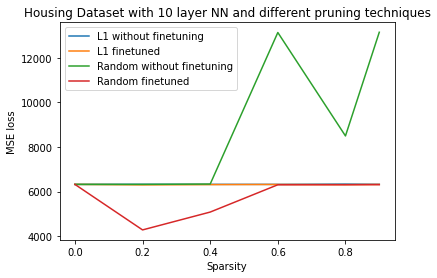

In [ ]:
import matplotlib.pyplot as plt

plt.title('Housing Dataset with 10 layer NN and different pruning techniques')
plt.plot(x_coord, results_base_l1, label = 'L1 without finetuning')
plt.plot(x_coord, results_finetune_l1, label = 'L1 finetuned')
plt.plot(x_coord, results_base_l2, label = 'Random without finetuning')
plt.plot(x_coord, results_finetune_l2, label = 'Random finetuned')
plt.ylabel('MSE loss')
plt.xlabel('Sparsity')
plt.legend()
plt.show()

# Archive

In [ ]:
net.parameters

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=8, bias=True)
  (fc6): Linear(in_features=8, out_features=8, bias=True)
  (fc7): Linear(in_features=8, out_features=4, bias=True)
  (fc8): Linear(in_features=4, out_features=4, bias=True)
  (fc9): Linear(in_features=4, out_features=2, bias=True)
  (fc10): Linear(in_features=2, out_features=1, bias=True)
)>

In [ ]:
parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [ ]:
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc3.weight == 0))
        / float(net.fc3.weight.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            + torch.sum(net.fc1.weight == 0)
            + torch.sum(net.fc2.weight == 0)
            + torch.sum(net.fc3.weight == 0)
        )
        / float(
            + net.fc1.weight.nelement()
            + net.fc2.weight.nelement()
            + net.fc3.weight.nelement()
        )
    )
)

Sparsity in fc1.weight: 91.75%
Sparsity in fc2.weight: 89.06%
Sparsity in fc3.weight: 92.19%
Global sparsity: 90.98%


In [ ]:
# Testing after pruning

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

6299.001349921068


In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['features'].to(device), data['price'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(inputs)
        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # for name, param in net.named_parameters():
        #   if param.requires_grad and name == 'fc2.weight':
        #     print(name, param.data)
        # print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 122181.137539
[1,   400] loss: 146072.629141
[2,   200] loss: 137330.837764
[2,   400] loss: 131440.652686
[3,   200] loss: 136169.098115
[3,   400] loss: 129041.408721
[4,   200] loss: 138213.130977
[4,   400] loss: 127328.475977
[5,   200] loss: 130457.387090
[5,   400] loss: 127137.012061
[6,   200] loss: 125147.003721
[6,   400] loss: 143463.541582
[7,   200] loss: 131718.300742
[7,   400] loss: 139262.185137
[8,   200] loss: 123157.821914
[8,   400] loss: 157254.663535
[9,   200] loss: 126901.994570
[9,   400] loss: 141942.693594
[10,   200] loss: 123002.345010
[10,   400] loss: 150233.661172
[11,   200] loss: 124628.028857
[11,   400] loss: 132072.065371
[12,   200] loss: 141475.281016
[12,   400] loss: 129519.830937
[13,   200] loss: 125851.403252
[13,   400] loss: 139541.558438
[14,   200] loss: 143665.514805
[14,   400] loss: 128431.276602
[15,   200] loss: 134079.954600
[15,   400] loss: 131773.914492
[16,   200] loss: 142269.049697
[16,   400] loss: 133414.5

In [ ]:
# Testing after finte-tuning with pruning

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

6287.0512013251055


## Plants classification

# Experiment 1


**Dataset - One hundred plants texture**

**Architecture - 3 layer Neural Network**

### Preliminary training

In [ ]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [ ]:
class HouseSalesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, train = True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.housing_data = pd.read_csv(csv_file)
        self.x = self.housing_data.drop('price', axis = 1)
        df = self.housing_data.drop('date', axis = 1)
        self.x = (df-df.mean())/df.std()
        self.y = self.housing_data[['price']]/1000

        if train:
          self.x = self.x.iloc[:18000, :]
          self.y = self.y.iloc[:18000, :]

        else:
          self.x = self.x.iloc[18000:, :]
          self.y = self.y.iloc[18000:, :]  


        print('Length = ', len(self.y))
        self.x = torch.Tensor(self.x.values).to(device)
        self.y = torch.Tensor(self.y.values).to(device)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # if self.transform:
        #     sample = self.transform(sample)

        features = self.x[idx]
        price = self.y[idx]
        return {'features': features, 'price': price}

In [ ]:
train_dataset = HouseSalesDataset(csv_file='kc_house_data.csv',
                                    root_dir='/', train = True)

test_dataset = HouseSalesDataset(csv_file='kc_house_data.csv',
                                    root_dir='/', train = False)

train_loader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

Length =  18000
Length =  3613


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 16)
        self.fc2 = nn.Linear(16, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [ ]:
# for i_batch, sample_batched in enumerate(dataloader):
#     print(i_batch, sample_batched['features'].size(),
#           sample_batched['price'].size())
#     outputs = net(sample_batched['features'])
#     print(outputs)
#     break

In [ ]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=10)
optimizer = optim.Adam(net.parameters(), lr=0.1)

In [ ]:
# Testing before training

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

19182.876130166474


In [ ]:
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['features'].to(device), data['price'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(inputs)
        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # for name, param in net.named_parameters():
        #   if param.requires_grad and name == 'fc2.weight':
        #     print(name, param.data)
        # print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 313454.279805
[1,   400] loss: 270775.208789
[2,   200] loss: 173404.642305
[2,   400] loss: 154073.499307
[3,   200] loss: 126168.431494
[3,   400] loss: 108649.528228
[4,   200] loss: 111971.183892
[4,   400] loss: 84915.198352
[5,   200] loss: 79682.803164
[5,   400] loss: 72777.883687
[6,   200] loss: 85777.619463
[6,   400] loss: 71730.381182
[7,   200] loss: 77663.372437
[7,   400] loss: 71133.666733
[8,   200] loss: 68441.446255
[8,   400] loss: 73085.686968
[9,   200] loss: 62232.009814
[9,   400] loss: 64691.638643
[10,   200] loss: 70460.636597
[10,   400] loss: 59321.271416
[11,   200] loss: 52715.929565
[11,   400] loss: 61801.528491
[12,   200] loss: 55852.758091
[12,   400] loss: 57513.918513
[13,   200] loss: 64912.645112
[13,   400] loss: 53955.008301
[14,   200] loss: 66313.721001
[14,   400] loss: 49822.689976
[15,   200] loss: 63912.291411
[15,   400] loss: 44110.129214
[16,   200] loss: 54497.053882
[16,   400] loss: 50188.705439
[17,   200] loss: 4

In [ ]:
# Testing after training

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

In [ ]:
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

In [ ]:
# dataiter = iter(testloader)
# images, labels = dataiter.next()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

RuntimeError: ignored

In [ ]:
# outputs = net(images)

### Global pruning

In [ ]:
net.parameters

In [ ]:
parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [ ]:
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc3.weight == 0))
        / float(net.fc3.weight.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            + torch.sum(net.fc1.weight == 0)
            + torch.sum(net.fc2.weight == 0)
            + torch.sum(net.fc3.weight == 0)
        )
        / float(
            + net.fc1.weight.nelement()
            + net.fc2.weight.nelement()
            + net.fc3.weight.nelement()
        )
    )
)

In [ ]:
# Testing after pruning

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['features'].to(device), data['price'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(inputs)
        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # for name, param in net.named_parameters():
        #   if param.requires_grad and name == 'fc2.weight':
        #     print(name, param.data)
        # print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

In [ ]:
# Testing after finte-tuning with pruning

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data['features'].to(device), data['price'].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)
    # forward + backward + optimize
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, labels)
    # for name, param in net.named_parameters():
    #   if param.requires_grad and name == 'fc2.weight':
    #     print(name, param.data)
    # print(loss)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

running_loss = running_loss / 2613
print(running_loss)

In [ ]:
module = net.fc1
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
prune.random_unstructured(module, name="weight", amount=0.15)

In [ ]:
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
print(module.weight)

In [ ]:
print(module._forward_pre_hooks)

In [ ]:
# prune.l1_unstructured(module, name="bias", amount=0.2)

In [ ]:
# print(list(module.named_parameters()))

In [ ]:
# print(list(module.named_buffers()))

In [ ]:
# print(module.bias)

In [ ]:
# print(module._forward_pre_hooks)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['features'], data['price']

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(inputs)
        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

## From the blog

### Local pruning

In [ ]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet().to(device=device)

In [ ]:
module = model.fc1
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
prune.random_unstructured(module, name="weight", amount=0.3)

In [ ]:
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
print(module.weight)

In [ ]:
print(module._forward_pre_hooks)

In [ ]:
prune.l1_unstructured(module, name="bias", amount=3)

In [ ]:
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
print(module.bias)

In [ ]:
print(module._forward_pre_hooks)

### Global pruning

In [ ]:
model = LeNet()

parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [ ]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv1.weight == 0))
        / float(model.conv1.weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv2.weight == 0))
        / float(model.conv2.weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc1.weight == 0))
        / float(model.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc2.weight == 0))
        / float(model.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc3.weight == 0))
        / float(model.fc3.weight.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model.conv1.weight == 0)
            + torch.sum(model.conv2.weight == 0)
            + torch.sum(model.fc1.weight == 0)
            + torch.sum(model.fc2.weight == 0)
            + torch.sum(model.fc3.weight == 0)
        )
        / float(
            model.conv1.weight.nelement()
            + model.conv2.weight.nelement()
            + model.fc1.weight.nelement()
            + model.fc2.weight.nelement()
            + model.fc3.weight.nelement()
        )
    )
)

### Custom pruning

In [ ]:
class FooBarPruningMethod(prune.BasePruningMethod):
    """Prune every other entry in a tensor
    """
    PRUNING_TYPE = 'unstructured'

    def compute_mask(self, t, default_mask):
        mask = default_mask.clone()
        mask.view(-1)[::2] = 0
        return mask

In [ ]:
def foobar_unstructured(module, name):
    """Prunes tensor corresponding to parameter called `name` in `module`
    by removing every other entry in the tensors.
    Modifies module in place (and also return the modified module)
    by:
    1) adding a named buffer called `name+'_mask'` corresponding to the
    binary mask applied to the parameter `name` by the pruning method.
    The parameter `name` is replaced by its pruned version, while the
    original (unpruned) parameter is stored in a new parameter named
    `name+'_orig'`.

    Args:
        module (nn.Module): module containing the tensor to prune
        name (string): parameter name within `module` on which pruning
                will act.

    Returns:
        module (nn.Module): modified (i.e. pruned) version of the input
            module

    Examples:
        >>> m = nn.Linear(3, 4)
        >>> foobar_unstructured(m, name='bias')
    """
    FooBarPruningMethod.apply(module, name)
    return module

In [ ]:
model = LeNet()
foobar_unstructured(model.fc3, name='bias')

print(model.fc3.bias_mask)